In [1]:
#!/usr/bin/env python3
import os
from functools import partial

os.environ["JAX_ENABLE_X64"] = "True"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import jax.numpy as jnp
import typer
from jax import jit, random, vmap
from jax._src.prng import PRNGKeyArray

from bpd import DATA_DIR
from bpd.draw import draw_gaussian
from bpd.initialization import init_with_truth
from bpd.io import save_dataset
from bpd.likelihood import gaussian_image_loglikelihood
from bpd.pipelines import pipeline_interim_samples_one_galaxy
from bpd.prior import interim_gprops_logprior
from bpd.sample import (
    get_target_images,
    get_true_params_from_galaxy_params,
    sample_target_galaxy_params_simple,
)

In [2]:
import blackjax
from blackjax.adaptation import pathfinder_adaptation

In [3]:

def sample_prior(
    rng_key: PRNGKeyArray,
    *,
    mean_logflux: float,
    sigma_logflux: float,
    shape_noise: float,
    g1: float = 0.02,
    g2: float = 0.0,
) -> dict[str, float]:
    k1, k2 = random.split(rng_key)

    lf = random.normal(k1) * sigma_logflux + mean_logflux
    other_params = sample_target_galaxy_params_simple(
        k2, shape_noise=shape_noise, g1=g1, g2=g2
    )

    return {"lf": lf, "hlr": 0.8, **other_params}

In [4]:
g1 = 0.02 
g2 = 0.0
shape_noise = 1e-3
mean_logflux = 6.0
sigma_logflux = 0.1
sigma_e_int=0.04
background = 1.0 
slen = 63
fft_size=256

## Vmap

In [5]:
n_gals = 2

In [6]:
rng_key = random.key(42)
pkey, nkey, gkey = random.split(rng_key, 3)

In [7]:
gkeys = random.split(gkey, n_gals)

In [8]:
# galaxy parameters from prior
pkeys = random.split(pkey, n_gals)
_get_galaxy_params = partial(
    sample_prior,
    shape_noise=shape_noise,
    mean_logflux=mean_logflux,
    sigma_logflux=sigma_logflux,
    g1=g1,
    g2=g2,
)
galaxy_params = vmap(_get_galaxy_params)(pkeys)
assert galaxy_params["x"].shape == (n_gals,)
assert galaxy_params["e1"].shape == (n_gals,)

In [9]:
# now get corresponding target images
draw_params = {**galaxy_params}
draw_params["f"] = 10 ** draw_params.pop("lf")
target_images = get_target_images(
    nkey, draw_params, background=background, slen=slen
)
assert target_images.shape == (n_gals, slen, slen)

In [10]:
true_params = vmap(get_true_params_from_galaxy_params)(galaxy_params)
fixed_params = {
    "x": true_params.pop("x"),
    "y": true_params.pop("y"),
    "f": 10 ** true_params.pop("lf"),
    "hlr": true_params.pop("hlr"),
}

In [11]:
_logprior = partial(
    interim_gprops_logprior,
    sigma_e=sigma_e_int,
    free_flux_hlr=False,
    free_dxdy=False,
)
_draw_fnc = partial(draw_gaussian, slen=slen, fft_size=fft_size)
_loglikelihood = partial(
    gaussian_image_loglikelihood,
    draw_fnc=_draw_fnc,
    background=background,
    free_flux_hlr=False,
    free_dxdy=False,
)

In [12]:
from bpd.chains import inference_loop
from functools import partial
from bpd.pipelines import logtarget_images


def run_inference_path_nuts(
    rng_key: PRNGKeyArray,
    init_positions,
    data,
    *,
    logtarget,
    n_samples: int=100,
    initial_step_size: float=1e-3,
    max_num_doublings: int=5,
    n_warmup_steps: int = 500,
    target_acceptance_rate: float = 0.80,
    is_mass_matrix_diagonal: bool = True,
):

    key1, key2 = random.split(rng_key)

    _logtarget = partial(logtarget, data=data)

    adapt = blackjax.pathfinder_adaptation(
        blackjax.nuts,
        _logtarget,
        initial_step_size=initial_step_size,
        target_acceptance_rate=target_acceptance_rate,
        max_num_doublings=max_num_doublings
    )

    (init_states, tuned_params), _ = adapt.run(key1, init_positions, n_warmup_steps)
    kernel = blackjax.nuts(_logtarget, **tuned_params).step
    states, _ = inference_loop(key2, init_states, kernel=kernel, n_samples=n_samples)
    return states.position


In [13]:
def pipeline_interim_samples_one_galaxy(
    rng_key,
    true_params: dict[str, float],
    target_image,
    fixed_params: dict[str, float],
    *,
    initialization_fnc,
    logprior,
    loglikelihood,
    n_samples: int = 100,
    max_num_doublings: int = 5,
    initial_step_size: float = 1e-3,
    n_warmup_steps: int = 500,
    is_mass_matrix_diagonal: bool = True,
):
    # Flux and HLR are fixed to truth and not inferred in this function.
    k1, k2 = random.split(rng_key)

    init_position = initialization_fnc(k1, true_params=true_params, data=target_image)

    _logtarget = partial(
        logtarget_images,
        logprior_fnc=logprior,
        loglikelihood_fnc=loglikelihood,
        fixed_params=fixed_params,
    )

    _inference_fnc = partial(
        run_inference_path_nuts,
        logtarget=_logtarget,
        is_mass_matrix_diagonal=is_mass_matrix_diagonal,
        n_warmup_steps=n_warmup_steps,
        max_num_doublings=max_num_doublings,
        initial_step_size=initial_step_size,
        n_samples=n_samples,
    )
    _run_inference = jit(_inference_fnc)

    interim_samples = _run_inference(k2, init_position, target_image)
    return interim_samples

In [14]:
from bpd.initialization import init_with_truth

In [15]:
pipe = partial(
    pipeline_interim_samples_one_galaxy,
    initialization_fnc=init_with_truth,
    logprior=_logprior,
    loglikelihood=_loglikelihood,
)
vpipe = vmap(jit(pipe))

In [16]:
# run_sampling = vmap(jit(partial(run_inference_path_nuts, logtarget=_logtarget, n_samples=100, initial_step_size=1e-3, max_num_doublings=5, n_warmup_steps=100)))

In [20]:
# compile
_ = vpipe(gkeys[0, None], {k:v[0, None] for k,v in true_params.items()}, target_images[0, None], {k:v[0, None] for k,v in fixed_params.items()})

In [19]:
%%time
samples = vpipe(gkeys, true_params, target_images, fixed_params)

CPU times: user 768 ms, sys: 3.74 ms, total: 772 ms
Wall time: 769 ms


In [22]:
samples['e1'].shape

(1, 100)

In [115]:
import matplotlib.pyplot as plt 

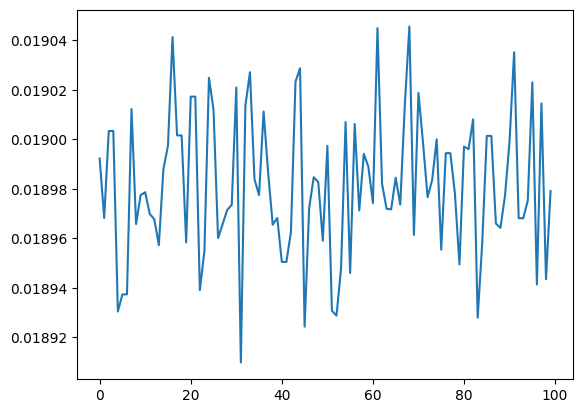

In [116]:
plt.plot(samples['e1'][0])

## Try adaptation on 1 galaxy now

In [82]:
rng_key = random.key(42)
pkey, nkey, gkey = random.split(rng_key, 3)

In [84]:
# galaxy parameters from prior
pkeys = random.split(pkey, n_gals)
_get_galaxy_params = partial(
    sample_prior,
    shape_noise=shape_noise,
    mean_logflux=mean_logflux,
    sigma_logflux=sigma_logflux,
    g1=g1,
    g2=g2,
)
galaxy_params = _get_galaxy_params(pkey)
galaxy_params['e1'].shape

()

In [86]:
# now get corresponding target images
draw_params = {**galaxy_params}
draw_params["f"] = 10 ** draw_params.pop("lf")
draw_params = 
target_images = get_target_images(
    nkey, draw_params, background=background, slen=slen
)
assert target_images.shape == (n_gals, slen, slen)

IndexError: tuple index out of range